In [2]:
import os
import sys
sys.path.insert(0,"/home/kal/CTCF/modules/")
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Must be before importing keras!
import tf_memory_limit
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import ctcfgen
from convnet import Bias
from keras.models import load_model
import keras.backend as K
import keras
import ucscgenome
import pandas
from scipy.special import logit
from scipy.special import expit as sigmoid
import viz_sequence


input_window = 256
batch_size = 32

model_path='/home/kal/CTCF/mass_CTCF/output/20170630_173919/20170630_173919_weights__289_0.95.hdf5'
gen_path='/home/kal/data/ctcfgen_data.hdf5'

bed_path = '/home/kal/data/final_atac.bed'
out_dir = os.path.dirname(model_path)

genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')

Using TensorFlow backend.


In [3]:
# Import the model params.
model = load_model(model_path, custom_objects={'Bias':Bias})
# load the generator
gen = ctcfgen.CTCFGeneratorhdf5(gen_path)
# load the bed file
peaks = pandas.read_table(bed_path, header=None)
peaks.columns = 'chr start end ctcf pwm ml'.split()

In [4]:
def softmax(batch):
    norm_batch = []
    for seq in batch:
        norm_batch.append([_softmax(base) for base in seq])
    return np.asarray(norm_batch)
    
def _softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

In [5]:
baseline = peaks[(abs(peaks['pwm'] - 10) < 1)]
baseline = baseline[baseline['ctcf']]
baseline = baseline[(abs(baseline['ml']) < .5)]

better = peaks[(abs(peaks['pwm'] - 10) < 1)]
better = better[better['ctcf']]
better = better[(better['ml'] > 10)]

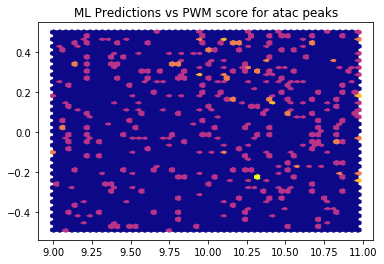

        chr      start        end  ctcf       pwm        ml
674    chr1   17013285   17014743  True   9.75868 -0.490237
686    chr1   17221480   17223747  True  10.66670 -0.168758
771    chr1   19577352   19579421  True   9.20377  0.468745
1217   chr1   28561791   28563719  True  10.76760 -0.375589
1230   chr1   28718109   28719317  True  10.24210 -0.443015
1338   chr1   31537300   31539502  True   9.50645 -0.197981
1819   chr1   42356102   42357962  True  10.06140  0.182542
2039   chr1   47047137   47049376  True   9.08887  0.139526
2211   chr1   52497749   52500197  True  10.81810  0.123758
2295   chr1   54354745   54356280  True  10.76760 -0.342285
2377   chr1   55738289   55739434  True   9.80962 -0.231722
2461   chr1   59527121   59529248  True  10.81810  0.353930
2674   chr1   65329145   65331570  True  10.67450  0.084401
2930   chr1   70670357   70672417  True   9.00198 -0.105007
3110   chr1   84763473   84765764  True  10.21270  0.444525
3323   chr1   90184824   90186327  True 

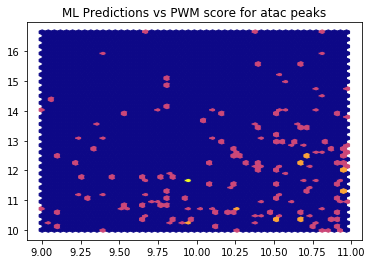

         chr      start        end  ctcf       pwm         ml
242     chr1    6787156    6788292  True   9.96047  11.658787
494     chr1   12335930   12337087  True  10.46490  10.651574
534     chr1   14421120   14422234  True  10.38620  15.536998
959     chr1   23983735   23984962  True   9.65779  10.453420
1185    chr1   27934705   27935841  True   9.66547  16.635610
1653    chr1   38955042   38956207  True   9.05243  14.333025
2983    chr1   74969434   74970648  True   9.30466  11.082557
3498    chr1   94928773   94929993  True  10.26310  10.023446
4184    chr1  120369281  120370424  True  10.96280  12.030350
5195    chr1  168114474  168115872  True  10.24210        inf
5453    chr1  173883001  173884242  True  10.91900  12.278811
5782    chr1  182564441  182565555  True  10.96280  11.972086
5968    chr1  186373189  186374452  True   9.05243  10.263886
7225    chr1  214758089  214759267  True   9.55690  10.719309
8915   chr10    6689295    6690755  True  10.86850  10.047938
9278   c

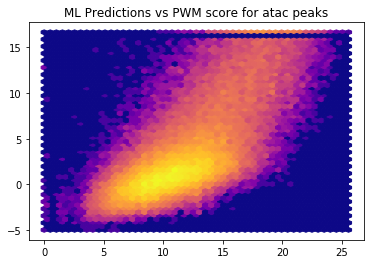

In [6]:
# make a plot of the two predictions vs each other
plt.hexbin(baseline['pwm'].tolist(), baseline['ml'].tolist(), gridsize=50, bins='log', cmap='plasma')
plt.title('ML Predictions vs PWM score for atac peaks')
plt.show()
print((baseline))

# make a plot of the two predictions vs each other
plt.hexbin(better['pwm'].tolist(), better['ml'].tolist(), gridsize=50, bins='log', cmap='plasma')
plt.title('ML Predictions vs PWM score for atac peaks')
plt.show()
print((better))

# make a plot of the two precitions vs each other
plt.hexbin(peaks['pwm'].tolist(), peaks['ml'].tolist(), gridsize=50, bins='log', cmap='plasma')
plt.title('ML Predictions vs PWM score for atac peaks')
plt.show()

In [7]:
def localize(row, verb=False):
    # break the sequence into overlapping tiles
    tile_seqs = list()
    num_tiles = int((row['end']-row['start']) / input_window) + ((row['end']-row['start']) % input_window > 0)
    if verb:
        print(num_tiles)
    for idx in range(num_tiles):
        if row['start'] + idx*input_window - input_window//2 > 0:
            seq = genome[row['chr']][row['start'] + idx*input_window - input_window//2:row['start'] + (idx+1)*input_window - input_window//2].lower()
            tile_seqs.append(ctcfgen.encode(np.fromstring(seq, dtype=np.uint8)))
        else:
            buffered_seq = np.zeros((256,4))
            buffered_seq[:row['start'] + (idx+1)*input_window - input_window//2] = genome[row['chr']][0:row['start'] + (idx+1)*input_window - input_window//2]
            tile_seqs.append(ctcfgen.encode(np.fromstring(buffered_seq).lower(), dtype=np.uint8))
        seq = genome[row['chr']][row['start'] + idx*input_window:row['start'] + (idx+1)*input_window].lower()
        tile_seqs.append(ctcfgen.encode(np.fromstring(seq, dtype=np.uint8)))
        
    tile_seqs= np.asarray(tile_seqs)
    tile_iter = iter(tile_seqs)
    
    # get a batch generator
    batches = ctcfgen.filled_batch(tile_iter, batch_size=batch_size)
    
    # figure out where the max prediction is coming from
    preds = list()
    for batch in batches:
        preds.append(model.predict_on_batch(batch))
    preds = np.asarray(preds).reshape((-1))[:tile_seqs.shape[0]]
    
    # get a tile centered there
    max_idx = np.argmax(preds)
    max_pred = np.max(preds)
    max_tile = batch.reshape((-1, 256, 4))[max_idx]
    if verb:
        print(max_idx)
        print(max_pred)
        print(preds)
    
    return max_tile, max_pred

In [8]:
def mutagenisis(seq):
    # do a mutant scan
    mutant_window=1

    # get a mutant batch generator
    mutant_gen = ctcfgen.ngram_mutant_gen(seq, n=mutant_window)
    g = ctcfgen.filled_batch(mutant_gen, batch_size=batch_size)
    
    # base importances as large-step gradients
    # score with base there - average of scores without base there
    mutant_preds = list()
    for batch in g:
        mutant_preds.append(model.predict_on_batch(batch))

    return np.asarray(mutant_preds).reshape((-1, 4))  

In [9]:
mutant_preds = list()
signal_seqs = list()

for index, row in baseline.iterrows():
    this_seq, max_pred = localize(row)
    these_preds = mutagenisis(this_seq)    
    signal_seqs.append(this_seq)
    mutant_preds.append(these_preds)

baseline['signal_seq'] = signal_seqs
baseline['mutant_preds']= mutant_preds

In [10]:
# write out the sequences in fasta format for further analysis
#write out a file
with open(os.path.join(out_dir, 'similar_baseline_seqs.fa'), 'w') as output:
    output.write('>prediction_ml|predictions_pwm\nsequence\n')
    len = 0
    for index, row in baseline.iterrows():
        if len < 220:
            output.write('>'+ str(row.name) + '|' + str(row['ml']) + '-' + str(row['pwm']) + '\n')
            output.write(ctcfgen.get_string(row['signal_seq']))

            print('>0-'+ str(row.name) + '|' + str(row['ml']) + '-' + str(row['pwm']))
            print(ctcfgen.get_string(row['signal_seq']))
            len = len + 1

>0-674|-0.4902368170449904-9.75868
gaggccacccccatgcagtgatgaccacggcccgttgtgaaccccgtggactttactcaagtctgtcacagcacttctcatgccatttggcagtgacttgctttccagatggagctcctggagtgctgggataatgttttcttcatatctgtatccacagcacacagcacagcgccaatcaagtctacagaggagctcttaggaaacgttttctcagtggtcaaaaagagaaggggtggaaccctccactcatctc
>0-686|-0.16875757506343195-10.6667
gtccgtggtctccagtctcttgggttctcaccctgtgtgaaaatcttcctgtttttccctaccccccaagtcacctcttacacagcctctgcttccaagcgcagcccccacaggagtttgtaggatttctgtgctagcggggagtgtgttctcacctcatagagccaggtagaaactacgcagatgggtgctgttctccaggaagaaagcagggcctttggggctctcagtgtccccgttgggttgtagacataac
>0-771|0.4687452642331899-9.20377
ccgagggccgtcccagagtcccccgcgccgccggggtcctaacggggtgcaccgtcttccgccgcacgtggattcagcgcgatgcccaaatccaagcgcgacaagaaaggtgggcgaagggggagtcgggaccctggggggagctccgtgggctggctacccagcctgcggtgagggcttcggggcggcgggggcgcagattggaacgccaggacatcctcgaggtgttccgctgcctcgctgcgagctggaatgg
>0-1217|-0.3755893650233572-10.7676
ctcccgtgattcgctactcctgtgttcatccgcccctccgtcgaccagattgggtgcttggccgtccctgccattagcgcgtaacgag

In [11]:
mutant_preds = list()
signal_seqs = list()

for index, row in better.iterrows():
    this_seq, max_pred = localize(row)
    these_preds = mutagenisis(this_seq)    
    signal_seqs.append(this_seq)
    mutant_preds.append(these_preds)

better['signal_seq'] = signal_seqs
better['mutant_preds']= mutant_preds

In [12]:
# write out the sequences in fasta format for further analysis
#write out a file
with open(os.path.join(out_dir, 'similar_better_seqs.fa'), 'w') as output:
    output.write('>prediction_ml|predictions_pwm\nsequence\n')
    len = 0
    for index, row in better.iterrows():
        if len < 220:
            output.write('>'+ str(row.name) + '|' + str(row['ml']) + '-' + str(row['pwm']) + '\n')
            output.write(ctcfgen.get_string(row['signal_seq']))

            print('>1-'+ str(row.name) + '|' + str(row['ml']) + '-' + str(row['pwm']))
            print(ctcfgen.get_string(row['signal_seq']))
            len = len + 1 

>1-242|11.658786881228275-9.96047
gaaattcatgaaggaatctggacatttagggggttcacagaatccgccgcttttagggaagattctctgcctgatgtgtgagcgctctaacctcttcatctgtgttcagtccccttgcaatgcttctctaaggtcggcctacatttcacttaattcagtggctctccactgggggcgctcttccccttgcaggggacatttggcaataaatgaataaatggggacatttttggttcttacaagggaggggagaggt
>1-494|10.651574247891087-10.4649
atttaacccagagcattgtgttgttggagcagcatacccgcgaggttctggtggagtcgcagctcctcctggcggaatttaaagtgaactgtatgcagcttggtgttgagagcaatggccggtacatttctgtgctcaaggtgtttggtaccaatgctcactttgtgaagaggccttatgatgctgaagtctccctaactgttcatggtttgctcctggtggataccatgcagacatatggtgctgattttgacct
>1-534|15.536997795871244-10.3862
aagctgagaccaaatagtgtttcccaacaggtatctaagaatgtagggcaggacaattctatgctgggcaacactgtgcaggatgaatgtttagcatccctgcctctctggccctgggtgtgtaccatcaccattcccttccgtgaacaatgaaatagtcttccaaatatttctaaatgtccctagggggcagtatttcccttggctgagaaccactgggagagccacatggcccatttcattctcactctcatct
>1-959|10.453420244035824-9.65779
gtgggacaccctggcttcctggaggcttgtcttcctcctgtcctgggactttaatgctttttcccatggccagccttgtaccagaactccagg

In [13]:
#make an iterator
iterator = better.iterrows()

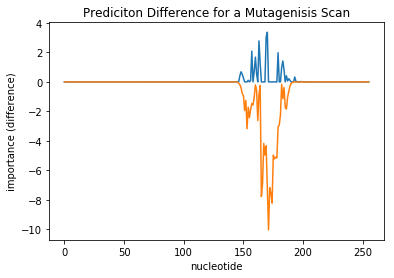

In [14]:
# pull out a sequence
index, test_row = next(iterator)
    
logit_preds = np.asarray(logit(test_row['mutant_preds']))
logit_max = test_row['ml']
if logit_max == np.inf:
    logit_max = np.nanmax(logit_preds[np.where(np.isfinite(logit_preds))])

diffs = logit_preds - logit_max
orig_diffs = diffs

for x in np.nditer(diffs, op_flags=['readwrite']):
    if x == np.inf:
        x[...] = np.nanmax(diffs[np.where(np.isfinite(diffs))])

# plot the gain-loss curve 
plt.plot(np.amax(diffs, axis=1))
plt.plot(np.amin(diffs, axis=1))
plt.title('Prediciton Difference for a Mutagenisis Scan')
plt.ylabel('importance (difference)')
plt.xlabel('nucleotide')
plt.show()

seq_center = np.argmax(np.max(abs(diffs), axis=1), axis=0)
seq = test_row['signal_seq'][seq_center-45:seq_center+45]

Starting sequence


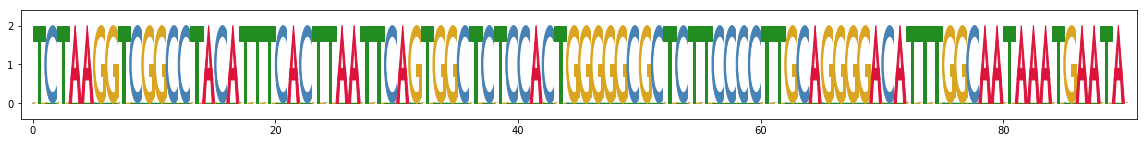

Differences


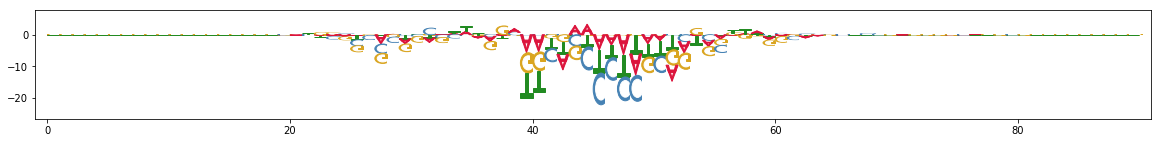

Softmax Prediction differences


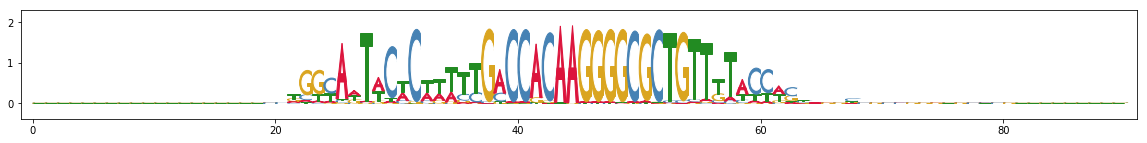

In [15]:
colors = {0:'crimson', 1:'steelblue', 2:'goldenrod', 3:'forestgreen'}

print('Starting sequence')
viz_sequence.plot_icweights(seq, colors=colors)
print('Differences')
viz_sequence.plot_weights(orig_diffs[seq_center-45:seq_center+45], colors=colors)
# visualize predicitons
print('Softmax Prediction differences')
_ = viz_sequence.plot_icweights(np.asarray([_softmax(base*10) for base in sigmoid(diffs)])[seq_center-45:seq_center+45], colors=colors)

Average prediction difference


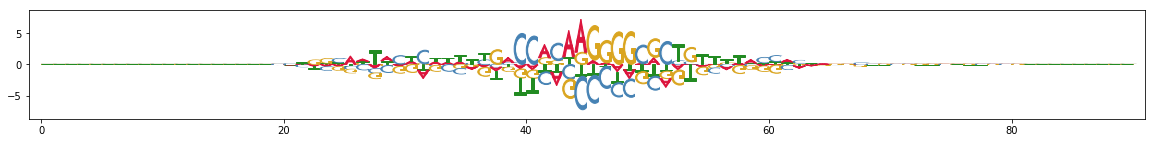

Masked average prediciton difference


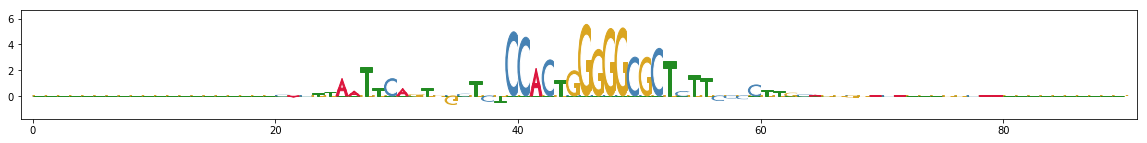

Softmax average prediction difference


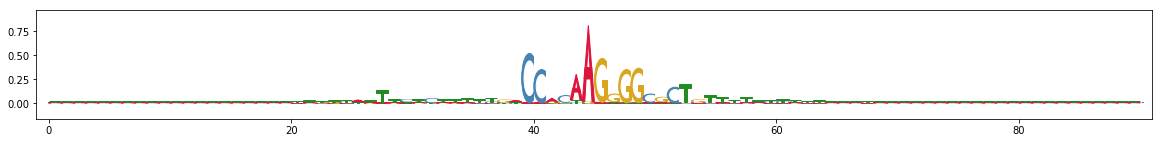

In [16]:
# plot the score differenece? 
preds = logit(test_row['mutant_preds'])[seq_center-45:seq_center+45]
for x in np.nditer(preds, op_flags=['readwrite']):
    if x == np.inf:
        x[...] = np.nanmax(preds[np.where(np.isfinite(preds))])

all_diffs = list()
for base_seq, base_preds in zip(seq, preds):
    this_base = list()
    for idx in range(4):
        this_base.append(base_preds[idx] - np.average(base_preds))
    all_diffs.append(list(this_base))

all_diffs=np.asarray(all_diffs)

print('Average prediction difference')    
viz_sequence.plot_weights(all_diffs, colors=colors)

score_diff = list()
for base_seq, base_preds in zip(seq, preds):
    idx = np.where(base_seq)
    score_diff.append(base_preds[idx] - np.average(base_preds))
      
score_diff = (seq * score_diff)
print('Masked average prediciton difference')
viz_sequence.plot_weights(score_diff, colors=colors)

print('Softmax average prediction difference')
_ = viz_sequence.plot_icweights(_softmax(all_diffs), colors=colors)

Masked average prediciton difference


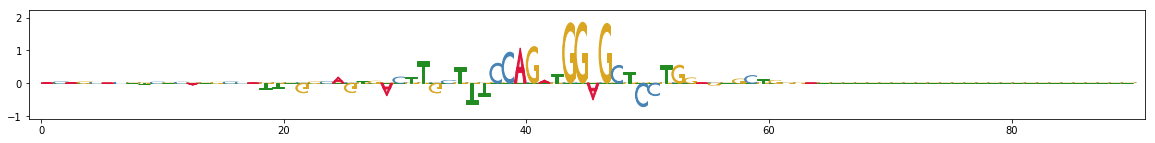

Masked average prediciton difference


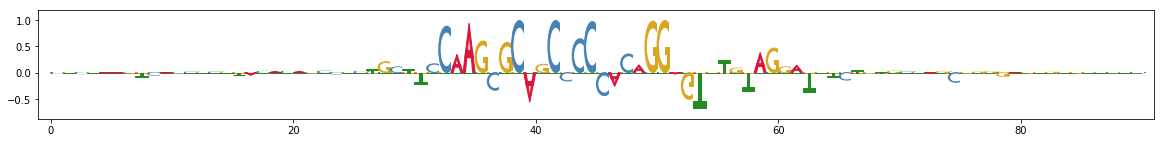

Masked average prediciton difference


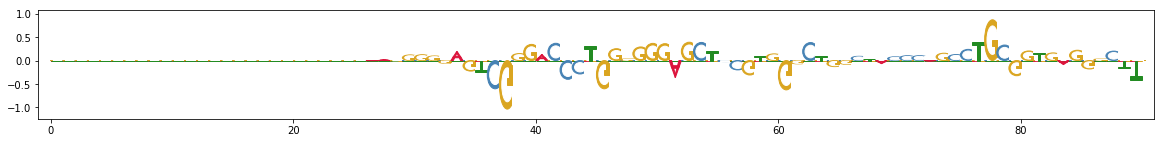

Masked average prediciton difference


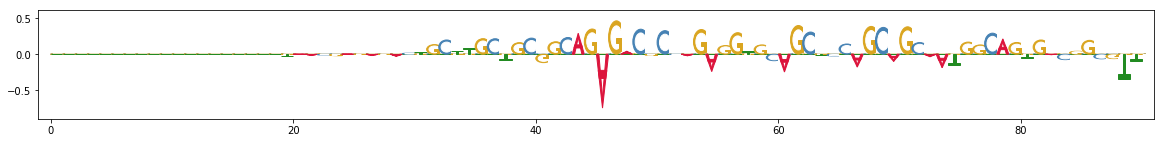

Masked average prediciton difference


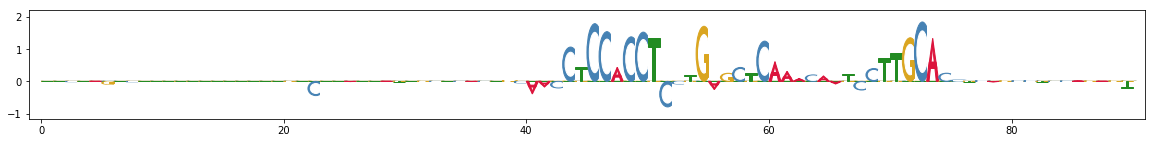

Masked average prediciton difference


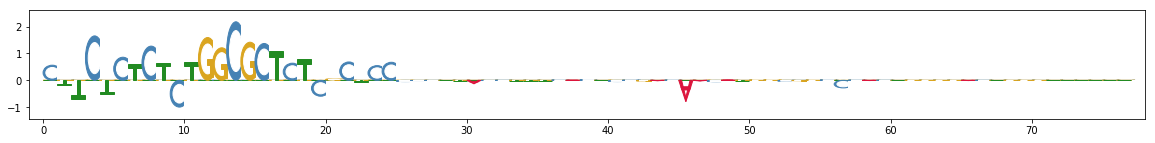

Masked average prediciton difference


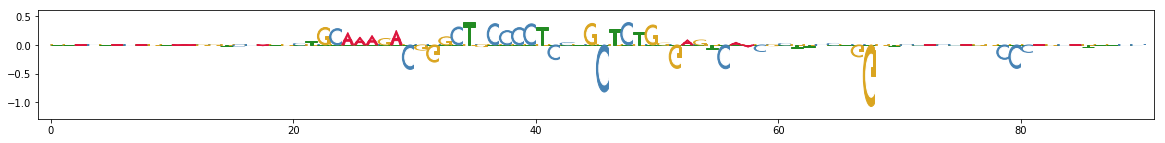

Masked average prediciton difference


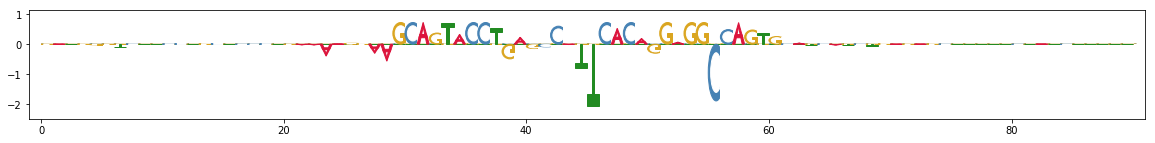

Masked average prediciton difference


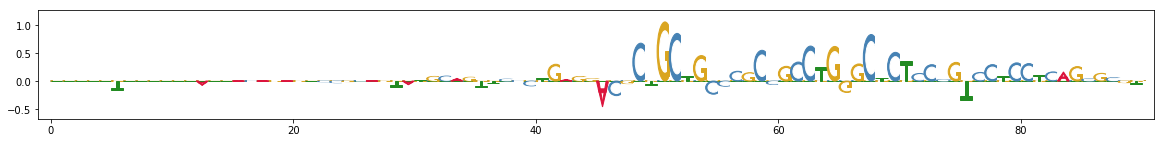

Masked average prediciton difference


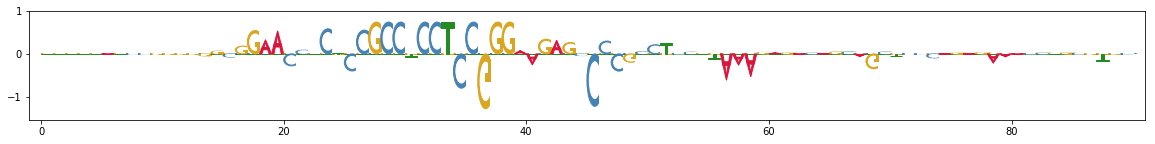

Masked average prediciton difference


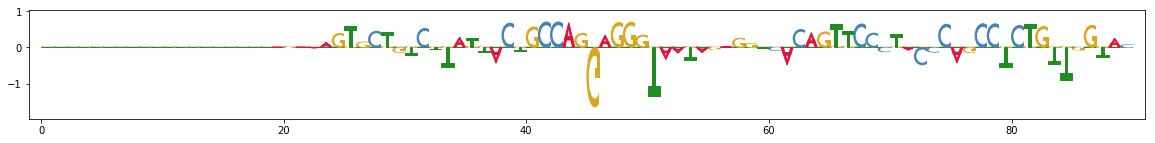

Masked average prediciton difference


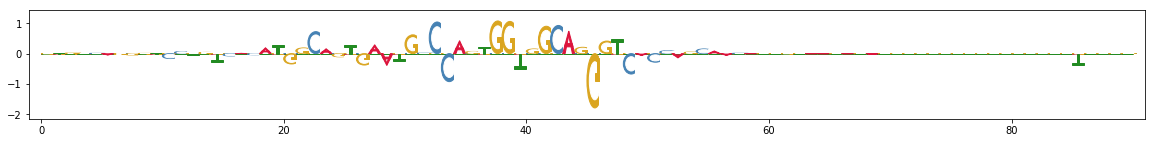

Masked average prediciton difference


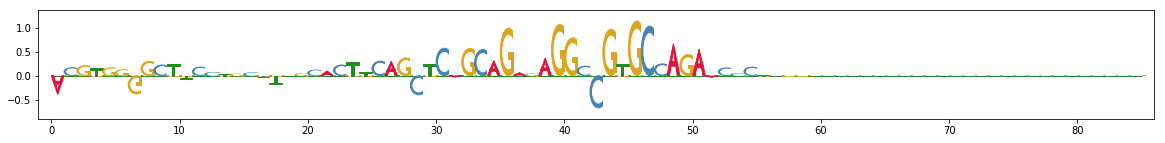

Masked average prediciton difference


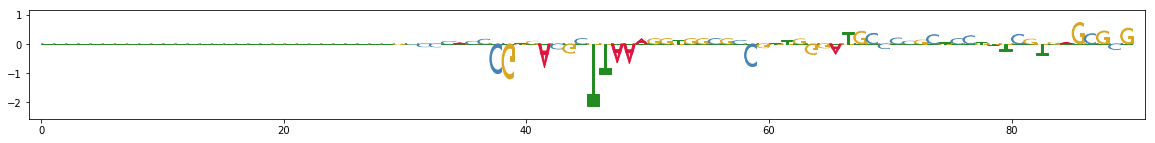

Masked average prediciton difference


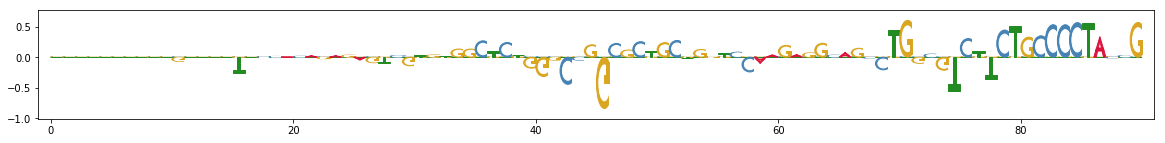

Masked average prediciton difference


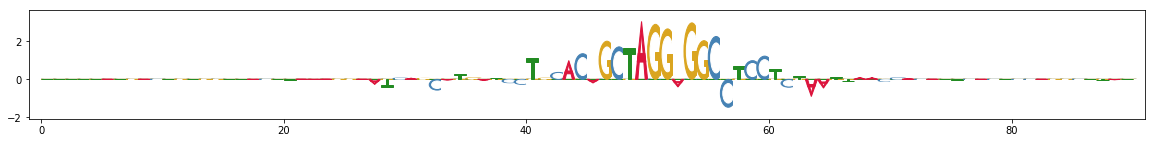

Masked average prediciton difference


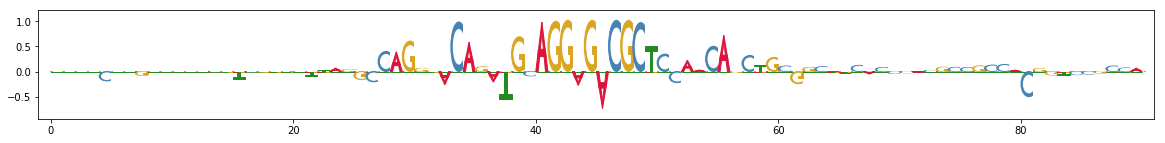

Masked average prediciton difference


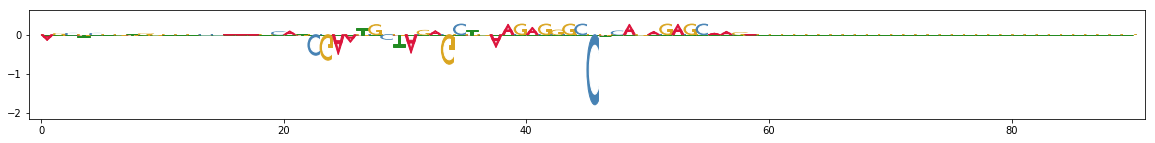

Masked average prediciton difference


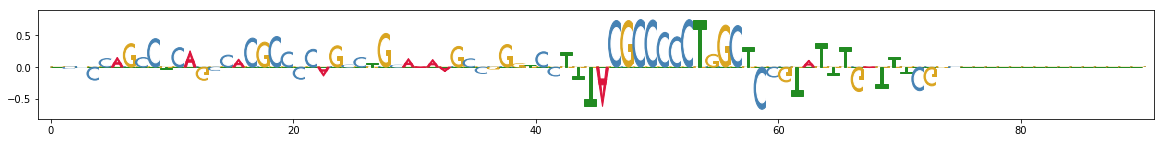

Masked average prediciton difference


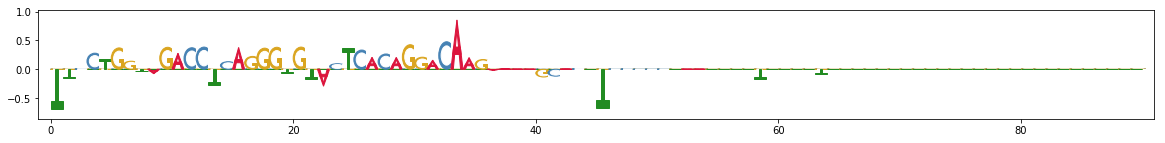

ValueError: Iteration of zero-sized operands is not enabled

In [17]:
count = 0
colors = {0:'crimson', 1:'steelblue', 2:'goldenrod', 3:'forestgreen'}

for index, row in baseline.iterrows():
    # get a sequence
    seq = row['signal_seq']

    # get the center
    logit_preds = np.asarray(logit(row['mutant_preds']))
    logit_max = row['ml']
    if logit_max == np.inf:
        logit_max = np.nanmax(logit_preds[np.where(np.isfinite(logit_preds))])

    diffs = logit_preds - logit_max
    orig_diffs = diffs
    
    for x in np.nditer(diffs, op_flags=['readwrite']):
        if x == np.inf:
            x[...] = np.nanmax(diffs[np.where(np.isfinite(diffs))])

    seq_center = np.argmax(np.max(abs(diffs), axis=1), axis=0)
    seq = seq[seq_center-45:seq_center+45]
    
    # plot the score differenece? 
    preds = logit(row['mutant_preds'])[seq_center-45:seq_center+45]
    for x in np.nditer(preds, op_flags=['readwrite']):
        if x == np.inf:
            x[...] = np.nanmax(preds[np.where(np.isfinite(preds))])

    score_diff = list()
    for base_seq, base_preds in zip(seq, preds):
        idx = np.where(base_seq)
        score_diff.append(base_preds[idx] - np.average(base_preds))
      
    score_diff = (seq * score_diff)
    print('Masked average prediciton difference')
    viz_sequence.plot_weights(score_diff, colors=colors)
    count =+ 1
    if count > 10:
        break

In [ ]:
def plot_key(seq, key_values, alpha=.6, background=0):
    cmap = cm.get_cmap('coolwarm')
    highlights=dict()
    
    for base, idx in zip(key_values, range(key_values.shape[0])):
        c = cmap(base)
        if base == background:
            new_color = (c[0], c[1], c[2], 0)
        else: 
            new_color = (c[0], c[1], c[2], alpha)
        try:
            highlights[new_color].append([idx, idx+1])
        except KeyError:
            highlights[new_color] = [[idx, idx+1]]
    
    colors = {0:'crimson', 1:'steelblue', 2:'goldenrod', 3:'forestgreen'}
    
    viz_sequence.plot_weights(seq, highlight=highlights, colors=colors)
    plt.show()

In [ ]:
# get highlighted sequence
gain_values = sigmoid(np.amax(diffs[seq_center-45:seq_center+45], axis=1))
loss_values = sigmoid(np.amax(-diffs[seq_center-45:seq_center+45], axis=1))

print('Gain')
plot_key(seq, gain_values, alpha=.8, background = gain_values[0])
print('Loss')
plot_key(seq, -loss_values + 1, alpha=.8, background = -loss_values[0] + 1)

In [ ]:
# pull out neuron activations for an intermediate layer and get average kernel activations for both sets of sequences

# get the symbolic outputs of each "key" layer.
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# build a function to get nueron activation
layer_name = 'conv1d_2'
seqs = model.input
get_activations = K.function([seqs, K.learning_phase()], [layer_dict[layer_name].output, model.output])

# get the batches for baseline seqs
g = ctcfgen.filled_batch(iter(baseline['signal_seq']), batch_size=32)
base_activations = list()
for input_batch in g:
    activations, predictions = get_activations([input_batch, 0])
    base_activations.append(activations)
    
# get the activations for baseline seqs
base_activations = np.asarray(base_activations)
base_activations = base_activations.reshape((-1, base_activations.shape[2], base_activations.shape[3]))
base_activations = np.sum(base_activations, axis=1)

# get the batches for better seqs
g = ctcfgen.filled_batch(iter(better['signal_seq']), batch_size=32)
better_activations = list()
for input_batch in g:
    activations, predictions = get_activations([input_batch, 0])
    better_activations.append(activations)
    
# get the activations for better seqs
better_activations = np.asarray(better_activations)
better_activations = better_activations.reshape((-1, better_activations.shape[2], better_activations.shape[3]))
better_activations = np.sum(better_activations, axis=1)

# plot those
cmap = plt.get_cmap('plasma')
print(base_activations.shape)
plt.imshow(base_activations, interpolation='nearest',
                    cmap = cmap, origin='lower', aspect='auto')
plt.show()
print(better_activations.shape)
plt.imshow(better_activations, interpolation='nearest',
                    cmap = cmap, origin='lower', aspect='auto')

plt.show()

both = np.asarray([np.average(better_activations, axis=0), np.average(base_activations, axis=0)])
print(both.shape)
plt.imshow(both, interpolation='nearest',
                    cmap = cmap, origin='lower', aspect='auto')
plt.show()

diff = both[0]- both[1]
plt.plot(diff)